In [1]:
!pip install gym
!pip install pygame
!pip install tf_agents==0.15.0
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gym
import numpy as np
import pygame
import time
import random
from gym import spaces
from gym.envs.registration import register
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

# player piece colors [player1, player2]
colors = ['#FF0000', '#0000FF']

# paths for each tile 1-35
node_combinations = [ 
    [(0,3), (1,5), (2,6), (4,7)], [(0,4), (1,5), (2,6), (3,7)], [(0,3), (1,6), (2,5), (4,7)], [(0,6), (1,5), (2,4), (3,7)],
    [(0,1), (2,3), (4,5), (6,7)], [(0,4), (1,5), (2,3), (6,7)], [(0,6), (1,5), (2,3), (4,7)], [(0,5), (1,4), (2,7), (3,6)],
    [(0,5), (1,4), (2,6), (3,7)], [(0,3), (1,4), (2,5), (6,7)], [(0,6), (1,4), (2,5), (3,7)], [(0,5), (1,4), (2,3), (6,7)],
    [(0,2), (1,3), (4,6), (5,7)], [(0,2), (1,3), (4,5), (6,7)], [(0,5), (1,3), (2,7), (4,6)], [(0,6), (1,3), (2,7), (4,5)],
    [(0,4), (1,3), (2,6), (5,7)], [(0,5), (1,3), (2,6), (4,7)], [(0,4), (1,3), (2,5), (6,7)], [(0,6), (1,3), (2,5), (4,7)],
    [(0,5), (1,3), (2,4), (6,7)], [(0,6), (1,3), (2,4), (5,7)], [(0,3), (1,2), (4,7), (5,6)], [(0,3), (1,2), (4,6), (5,7)],
    [(0,3), (1,2), (4,5), (6,7)], [(0,4), (1,2), (3,7), (5,6)], [(0,5), (1,2), (3,7), (4,6)], [(0,6), (1,2), (3,7), (4,5)],
    [(0,4), (1,2), (3,6), (5,7)], [(0,5), (1,2), (3,6), (4,7)], [(0,4), (1,2), (3,5), (6,7)], [(0,6), (1,2), (3,5), (4,7)],
    [(0,5), (1,2), (3,4), (6,7)], [(0,6), (1,2), (3,4), (5,7)], [(0,7), (1,2), (3,4), (5,6)]
]


In [3]:
class Tile():
    def __init__(self, tile_num, tile_connections):
        self.tile_num = tile_num
        self.image = pygame.image.load("TsuroImages/" + str(tile_num) + ".png")
        self.image = pygame.transform.scale(self.image, (100, 100))
        self.tile_connections = tile_connections
        self.rotation = 1
    
    def move(self, current_node):
        next_node = 0
        next_player_tile = 0
        for connection in self.tile_connections:
            if current_node in connection:
                n1, n2 = connection
                if n1 == current_node:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n2)
                else:
                    next_node, next_player_tile, next_x, next_y = self.new_tile_node(n1)
                return next_node, next_player_tile, next_x, next_y
        raise Exception("Issue in moving players")
    
    # update number of times rotation should be applied to connections and image
    def rotate_tile(self, rotate):
        self.image = pygame.transform.rotate(self.image, rotate * -90)
        self.tile_connections = [tuple((element + (2 * rotate)) % 8 for element in couple ) for couple in self.tile_connections]
        self.rotation = 1 if (self.rotation + 1 % 4 == 0) else self.rotation + 1
        
    def get_rotation(self):
        return self.rotation
    
    def new_tile_node(self, current_node):
        next_node = 0
        next_x = 0
        next_y = 0
        next_player_tile = 0
        match current_node:
            case 0:
                next_node = 3
                next_player_tile = -1
                next_x = -1
            case 1:
                next_node = 6
                next_player_tile = -6
                next_y = -1
            case 2:
                next_node = 5
                next_player_tile = -6
                next_y = -1
            case 3:
                next_node = 0
                next_player_tile = 1
                next_x = 1
            case 4:
                next_node = 7
                next_player_tile = 1
                next_x = 1
            case 5:
                next_node = 2
                next_player_tile = 6
                next_y = 1
            case 6:
                next_node = 1
                next_player_tile = 6
                next_y = 1
            case 7:
                next_node = 4
                next_player_tile = -1
                next_x = -1
            case _:
                raise Exception("Issue in tile board")
                
        return next_node, next_player_tile, next_x, next_y
    

In [4]:
class TsuroEnv(gym.Env):
    #
    def __init__(self):
        self.screen = None
        self.current_player = 1
        self.num_tiles = 35
        self.tile_board_size = (6, 6)
        self.rotation_board_size = (6, 6)
        self.player_board_size = (36,8)
        self.num_players = 2
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)

        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
        
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        self.rotation_board = np.zeros(self.rotation_board_size, dtype = int)
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)

        self.action_space = spaces.Discrete(11)
        self.observation_space = spaces.Box(low=-1, high=140, shape=(327,))
        
    def get_tile_obs(self):
        temp = self.rotation_board.flatten()
        temp1 = self.tile_board.flatten()
        for i in range(35):
            temp[i] = ((temp[i] - 1) * 35) + temp1[i]
        return temp
        
    # Resets the environment to default state
    def reset(self): 
        self.current_player = 1
        self.rotation_board = np.zeros(self.rotation_board_size, dtype = int)
        self.tile_board = np.zeros(self.tile_board_size, dtype = int)
        self.player_board = np.zeros(self.player_board_size, dtype = int)
        
        self.tiles = []
        for i in range(self.num_tiles):
            self.tiles.append(Tile(i, node_combinations[i]))
            
        self.remaining_tiles = []
        for i in range(self.num_tiles):
            self.remaining_tiles.append(i)
        random.shuffle(self.remaining_tiles)
            
        self.remaining_players = []
        for i in range(self.num_players):
            self.remaining_players.append(i+1)
            
        self.player_tiles = []
        for i in range(self.num_players):
            player_tiles = []
            for i in range(3):
                player_tiles.append(self.remaining_tiles.pop())
            self.player_tiles.append(player_tiles)
            
        #########################################
        #TODO: TESTING STUFF TO BE REMOVED LATER#
        #########################################
        for i in range(self.num_players):
            self.player_board[random.randint(0,5)][i+1] = i+1
            
        initial_obs = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))

        return initial_obs
    
    # Makes a move in the game based on inputs from player or AI
    def step(self, action = -2, move = -1):
        if move == -1:
            card, rotate = self.get_card(action)
        else:
            card = move
            rotate = 0
        
        action = self.player_tiles[self.current_player - 1][card]
        
        if action == -1:
            observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))
            reward = -1
            done = 0
            return observation, reward, done, {}
            
        # Removes used tile and adds new tile from deck to hand
        self.player_tiles[self.current_player-1].remove(action)
        if len(self.remaining_tiles) > 0:
            self.player_tiles[self.current_player-1].append(self.remaining_tiles.pop())
        else:
            self.player_tiles[self.current_player-1].append(-1)
        
        # Rotates tile (Only used by AI)
        self.tiles[action].rotate_tile(rotate)
        
        reward = 0
        self.place_tile(action+1)
        self.move_players()
        reward = self.reward_function()
        if self.game_is_over():
            done = 1
        else:
            done = 0
        self.current_player = self.next_player()
        observation = np.hstack((self.player_tiles[self.current_player - 1], self.player_board.flatten(), self.get_tile_obs()))
        return observation, reward, done, {}
    
    # Decides if the game is over
    def game_is_over(self):
        if len(self.remaining_players) <= 1:
            return True
        return False
    
    # Decides the reward (Only used for AI)
    def reward_function(self):
        if not self.game_is_over():
            return 1
        if self.game_is_over() and self.current_player in self.remaining_players:
            return 2
        return -1
    
    # Places tile in self.tile_board
    def place_tile(self, tile):
        tile_number, node_number = np.where(self.player_board == self.current_player)
        x, y = TsuroEnv.euclidean_division(self, tile_number)
        x = x[0]
        y = y[0]
        self.tile_board[x][y] += tile
        self.rotation_board[x][y] += self.tiles[tile-1].get_rotation()
    
    # Moves player piece in self.player_board
    def move_players(self):
        for player in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == player)
            x, y = TsuroEnv.euclidean_division(self, tile_number)
            x = x[0]
            y = y[0]
            while self.tile_board[x][y] != 0:
                tile = self.tiles[(self.tile_board[x][y])-1]
                next_node, next_player_tile, next_x, next_y = tile.move(node_number)
                self.player_board[tile_number[0]][node_number[0]] = 0
                if ((tile_number[0] % 6 == 0) and ((tile_number[0] + next_player_tile) % 6 == 5)) or (tile_number[0] + next_player_tile < 0) or (tile_number[0] + next_player_tile > 35) or ((tile_number[0] % 6 == 5) and ((tile_number[0] + next_player_tile) % 6 == 0)):
                    self.remaining_players.remove(player)
                    break
                else:
                    self.player_board[tile_number[0] + next_player_tile][next_node] = player
                    x += next_x
                    y += next_y
                    tile_number, node_number = np.where(self.player_board == player)
    
    # Quotient and Remainder
    def euclidean_division(self, x, y = 6):
        return x % y, x // y
    
    # Action (card, rotation) from input
    def get_card(self, x, y = 4):
        return  x // y, x % y

    # Decide whos turn it is
    def next_player(self):
        if len(self.remaining_players) == 0:
            return -1
        if self.current_player not in self.remaining_players:
            for player in self.remaining_players:
                if player > self.current_player:
                    return player
                else:
                    return self.remaining_players[0]
        return self.remaining_players[(self.remaining_players.index(self.current_player) + 1) % len(self.remaining_players)]
        
    # Render the environment
    def render(self, mode):
        screen = pygame.display.set_mode((650, 750))
        screen.fill((255, 255, 255))

        # Draw the game board
        board = pygame.image.load("TsuroImages/board.png")
        board = pygame.transform.scale(board, (600, 600))
        screen.blit(board, (25,25))
        
        # Draw current players hand
        for i in range (len(self.player_tiles[self.current_player-1])):
            tile = self.player_tiles[self.current_player-1][i]
            screen.blit(self.tiles[tile].image, (75 + (i * 200), 635))
        
        # Draw the tiles on the board
        for x in range(self.tile_board_size[0]):
            for y in range(self.tile_board_size[1]):
                val = self.tile_board[x][y]
                if val != 0:
                    tile = self.tiles[val-1]
                    screen.blit(tile.image, (25 + x * 100, 25 + y * 100))
                    
        # Draw the players' pieces on the board
        for i in self.remaining_players:
            tile_number, node_number = np.where(self.player_board == i)
            y_add = 0
            x_add = 0
            y_mult = 0
            x_mult = 0
            
            match node_number[0]:
                case 0:
                    y_add = 35
                case 1:
                    x_add = 35
                case 2:
                    x_add = 70
                case 3:
                    x_add = 100
                    y_add = 35
                case 4:
                    x_add = 100
                    y_add = 70
                case 5:
                    x_add = 70
                    y_add = 100
                case 6:
                    x_add = 35
                    y_add = 100
                case 7:
                     y_add = 70
                case _:
                    raise Exception("Issue in drawing the player board")
                    
            if tile_number[0] != 0:
                x_mult, y_mult = TsuroEnv.euclidean_division(self, tile_number[0])
            
            pygame.draw.circle(screen, colors[i-1], (25 + x_add + (100 * x_mult), 25 + y_add + (100 * y_mult)), 5)
            
        # Draw text to show who won when game is over
        if self.game_is_over() or self.current_player == -1:
            font = pygame.font.Font('freesansbold.ttf', 32)
            text = font.render('Player ' + str(self.current_player) + ' wins', True, '#00FF00')
            textRect = text.get_rect()
            textRect.center = (650 // 2, 750 // 2)
            screen.blit(text, textRect)
            
        pygame.display.update()



In [5]:
num_iterations = 3010000

initial_collect_steps = 10000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 100
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 500
eval_interval = 5000

register(
    id='TsuroEnv',
    entry_point=TsuroEnv,
)

env_name = "TsuroEnv"

train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

fc_layer_params = (200, 100)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    return tf.keras.layers.Dense(num_units, activation=tf.keras.activations.relu, kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'))

dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03), bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
    
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step)
    # commenting out render will make training quicker
    # environment.render("human")
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)
        
train_checkpointer = common.Checkpointer(
    ckpt_dir="Checkpoints/",
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

agent.train = common.function(agent.train)

agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)
        train_checkpointer.save(train_step_counter)
        with open("Checkpoints/returns.txt", "w") as txt:
            for item in returns:
                txt.write(str(item) + "\n")

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 1123721344.0
step = 400: loss = 2807887036416.0
step = 600: loss = 31205232640.0
step = 800: loss = 193210176.0
step = 1000: loss = 913777856.0
step = 1200: loss = 629697920.0
step = 1400: loss = 1536769024.0
step = 1600: loss = 225017776.0
step = 1800: loss = 2240871168.0
step = 2000: loss = 20603224064.0
step = 2200: loss = 3412155392.0
step = 2400: loss = 20232718336.0
step = 2600: loss = 5296195072.0
step = 2800: loss = 16303355904.0
step = 3000: loss = 100501086208.0
step = 3200: loss = 70277292032.0
step = 3400: loss = 149800501248.0
step = 3600: loss = 625625464832.0
step = 3800: loss = 108404842496.0
step = 4000: loss = 30743474176.0
step = 4200: loss = 13740308480.0
step = 4400: loss = 80329891840.0
step = 4600: loss = 46914400256.0
step = 4800: loss = 740863049728.0
step = 5000: loss = 9811067904.0
step = 5000: Average Return = 2.0399999618530273
step = 5200: loss = 15196080128.0
step = 5400: loss = 20573898752.0
step = 5600: loss = 44293308416.0
step = 580

step = 45600: loss = 9771520.0
step = 45800: loss = 12.007333755493164
step = 46000: loss = 12.756434440612793
step = 46200: loss = 36116224.0
step = 46400: loss = 11.169792175292969
step = 46600: loss = 11.607149124145508
step = 46800: loss = 14.471813201904297
step = 47000: loss = 6337756.5
step = 47200: loss = 473624.28125
step = 47400: loss = 10.025527954101562
step = 47600: loss = 14.047324180603027
step = 47800: loss = 13.500061988830566
step = 48000: loss = 9.605849266052246
step = 48200: loss = 14.771659851074219
step = 48400: loss = 13.116830825805664
step = 48600: loss = 9.875768661499023
step = 48800: loss = 12.849771499633789
step = 49000: loss = 10.048969268798828
step = 49200: loss = 5865902.5
step = 49400: loss = 10.21965217590332
step = 49600: loss = 11.412603378295898
step = 49800: loss = 12.91318130493164
step = 50000: loss = 15.457480430603027
step = 50000: Average Return = 3.5399999618530273
step = 50200: loss = 209805.15625
step = 50400: loss = 6496576.5
step = 506

step = 88200: loss = 15.418307304382324
step = 88400: loss = 283702.21875
step = 88600: loss = 15.017817497253418
step = 88800: loss = 12.832059860229492
step = 89000: loss = 9.467642784118652
step = 89200: loss = 11.806388854980469
step = 89400: loss = 12.724126815795898
step = 89600: loss = 14.533331871032715
step = 89800: loss = 21817.4765625
step = 90000: loss = 9.241570472717285
step = 90000: Average Return = 3.2739999294281006
step = 90200: loss = 21.132699966430664
step = 90400: loss = 16.341867446899414
step = 90600: loss = 11.795804977416992
step = 90800: loss = 13.333805084228516
step = 91000: loss = 13.117701530456543
step = 91200: loss = 10.304977416992188
step = 91400: loss = 14.068294525146484
step = 91600: loss = 13.871599197387695
step = 91800: loss = 462368.15625
step = 92000: loss = 4641161.5
step = 92200: loss = 13.592094421386719
step = 92400: loss = 10.79153823852539
step = 92600: loss = 12.110780715942383
step = 92800: loss = 13.170839309692383
step = 93000: loss 

step = 130200: loss = 17.074644088745117
step = 130400: loss = 18.610681533813477
step = 130600: loss = 20.48511505126953
step = 130800: loss = 24.390609741210938
step = 131000: loss = 24.951513290405273
step = 131200: loss = 22.45748519897461
step = 131400: loss = 23.945268630981445
step = 131600: loss = 19.772140502929688
step = 131800: loss = 23.15363311767578
step = 132000: loss = 1654.88623046875
step = 132200: loss = 29.633817672729492
step = 132400: loss = 26.57250213623047
step = 132600: loss = 21.90799331665039
step = 132800: loss = 26.628265380859375
step = 133000: loss = 24.190919876098633
step = 133200: loss = 24.14651870727539
step = 133400: loss = 20.157312393188477
step = 133600: loss = 18.869577407836914
step = 133800: loss = 21.887863159179688
step = 134000: loss = 22.925472259521484
step = 134200: loss = 24.961671829223633
step = 134400: loss = 22.31022834777832
step = 134600: loss = 15.774137496948242
step = 134800: loss = 22.47249412536621
step = 135000: loss = 24.8

step = 169200: loss = 3.965299367904663
step = 169400: loss = 3.9440038204193115
step = 169600: loss = 2.736379623413086
step = 169800: loss = 2.637972354888916
step = 170000: loss = 3.743199348449707
step = 170000: Average Return = 3.7019999027252197
step = 170200: loss = 4.162408828735352
step = 170400: loss = 4.2482099533081055
step = 170600: loss = 4.757842063903809
step = 170800: loss = 4.044637203216553
step = 171000: loss = 5.458441257476807
step = 171200: loss = 4.391542434692383
step = 171400: loss = 5.085024833679199
step = 171600: loss = 3.059649705886841
step = 171800: loss = 3.897629499435425
step = 172000: loss = 2.856241464614868
step = 172200: loss = 4.5884809494018555
step = 172400: loss = 3.456711769104004
step = 172600: loss = 3.784459352493286
step = 172800: loss = 4.9034104347229
step = 173000: loss = 2.7211625576019287
step = 173200: loss = 3.476386547088623
step = 173400: loss = 3.9057188034057617
step = 173600: loss = 4.109488010406494
step = 173800: loss = 3.89

step = 208000: loss = 3.6901204586029053
step = 208200: loss = 3.3665177822113037
step = 208400: loss = 4.7497358322143555
step = 208600: loss = 3.151871919631958
step = 208800: loss = 3.516646146774292
step = 209000: loss = 3.6226370334625244
step = 209200: loss = 3.703528642654419
step = 209400: loss = 3.5824055671691895
step = 209600: loss = 3.1560986042022705
step = 209800: loss = 3.8642184734344482
step = 210000: loss = 4.325439453125
step = 210000: Average Return = 3.3540000915527344
step = 210200: loss = 4.054011344909668
step = 210400: loss = 3.8912136554718018
step = 210600: loss = 3.729508876800537
step = 210800: loss = 3.9484453201293945
step = 211000: loss = 2.8553435802459717
step = 211200: loss = 4.231415748596191
step = 211400: loss = 4.116329669952393
step = 211600: loss = 4.305219650268555
step = 211800: loss = 4.070087909698486
step = 212000: loss = 2.958933115005493
step = 212200: loss = 3.007016897201538
step = 212400: loss = 4.181427478790283
step = 212600: loss = 

step = 246600: loss = 4.432008743286133
step = 246800: loss = 4.682179927825928
step = 247000: loss = 4.08561372756958
step = 247200: loss = 4.079998016357422
step = 247400: loss = 3.5486035346984863
step = 247600: loss = 4.064948081970215
step = 247800: loss = 3.840745687484741
step = 248000: loss = 3.437333345413208
step = 248200: loss = 3.8216052055358887
step = 248400: loss = 4.336498737335205
step = 248600: loss = 3.746824264526367
step = 248800: loss = 2.883610248565674
step = 249000: loss = 3.8488028049468994
step = 249200: loss = 3.300440549850464
step = 249400: loss = 3.94577956199646
step = 249600: loss = 3.4575631618499756
step = 249800: loss = 4.357372760772705
step = 250000: loss = 3.808166027069092
step = 250000: Average Return = 3.625999927520752
step = 250200: loss = 4.656014442443848
step = 250400: loss = 3.598879337310791
step = 250600: loss = 4.074584484100342
step = 250800: loss = 2.534825325012207
step = 251000: loss = 5.302536487579346
step = 251200: loss = 4.4717

step = 285400: loss = 3.8905580043792725
step = 285600: loss = 3.5633761882781982
step = 285800: loss = 3.543858289718628
step = 286000: loss = 4.209866046905518
step = 286200: loss = 2.9376487731933594
step = 286400: loss = 3.73970365524292
step = 286600: loss = 4.143883228302002
step = 286800: loss = 5.460856914520264
step = 287000: loss = 3.285283088684082
step = 287200: loss = 3.429023265838623
step = 287400: loss = 4.601942539215088
step = 287600: loss = 3.2686192989349365
step = 287800: loss = 3.1955087184906006
step = 288000: loss = 4.881481170654297
step = 288200: loss = 4.182316303253174
step = 288400: loss = 4.594123840332031
step = 288600: loss = 4.426324844360352
step = 288800: loss = 3.611804962158203
step = 289000: loss = 4.6759467124938965
step = 289200: loss = 2.926619291305542
step = 289400: loss = 4.61800479888916
step = 289600: loss = 3.7905995845794678
step = 289800: loss = 4.936891555786133
step = 290000: loss = 4.105543613433838
step = 290000: Average Return = 3.4

step = 324600: loss = 4.920358657836914
step = 324800: loss = 3.532327175140381
step = 325000: loss = 4.2956223487854
step = 325000: Average Return = 3.7179999351501465
step = 325200: loss = 3.0574450492858887
step = 325400: loss = 3.235755205154419
step = 325600: loss = 3.7533648014068604
step = 325800: loss = 4.368046760559082
step = 326000: loss = 3.3620824813842773
step = 326200: loss = 4.367936134338379
step = 326400: loss = 4.069698810577393
step = 326600: loss = 4.457294940948486
step = 326800: loss = 4.568551540374756
step = 327000: loss = 3.489142656326294
step = 327200: loss = 3.386355400085449
step = 327400: loss = 3.7072668075561523
step = 327600: loss = 4.107048034667969
step = 327800: loss = 4.009626388549805
step = 328000: loss = 3.4662086963653564
step = 328200: loss = 3.940592050552368
step = 328400: loss = 4.33596658706665
step = 328600: loss = 3.3389363288879395
step = 328800: loss = 3.692751169204712
step = 329000: loss = 4.434295177459717
step = 329200: loss = 3.63

step = 363400: loss = 3.6446075439453125
step = 363600: loss = 3.297135591506958
step = 363800: loss = 4.704494953155518
step = 364000: loss = 4.7050580978393555
step = 364200: loss = 4.422110080718994
step = 364400: loss = 4.203841686248779
step = 364600: loss = 3.367530107498169
step = 364800: loss = 4.767885208129883
step = 365000: loss = 4.041639804840088
step = 365000: Average Return = 3.7239999771118164
step = 365200: loss = 5.010284423828125
step = 365400: loss = 5.151853084564209
step = 365600: loss = 2.403554677963257
step = 365800: loss = 4.040950775146484
step = 366000: loss = 3.5006444454193115
step = 366200: loss = 5.254630088806152
step = 366400: loss = 3.8395049571990967
step = 366600: loss = 5.0228776931762695
step = 366800: loss = 4.242390155792236
step = 367000: loss = 3.5746757984161377
step = 367200: loss = 4.245139122009277
step = 367400: loss = 3.1622416973114014
step = 367600: loss = 2.9345364570617676
step = 367800: loss = 4.529909610748291
step = 368000: loss =

step = 402200: loss = 4.016830921173096
step = 402400: loss = 4.011528015136719
step = 402600: loss = 4.761809349060059
step = 402800: loss = 3.448603391647339
step = 403000: loss = 2.2121269702911377
step = 403200: loss = 4.7850847244262695
step = 403400: loss = 4.082205295562744
step = 403600: loss = 2.797180652618408
step = 403800: loss = 3.802565574645996
step = 404000: loss = 4.969161033630371
step = 404200: loss = 3.203907012939453
step = 404400: loss = 3.848871946334839
step = 404600: loss = 3.2334063053131104
step = 404800: loss = 4.038869380950928
step = 405000: loss = 4.324557781219482
step = 405000: Average Return = 3.7320001125335693
step = 405200: loss = 4.476733684539795
step = 405400: loss = 4.851354598999023
step = 405600: loss = 3.9350955486297607
step = 405800: loss = 4.449468612670898
step = 406000: loss = 3.327707529067993
step = 406200: loss = 3.8946540355682373
step = 406400: loss = 4.367618560791016
step = 406600: loss = 4.068412780761719
step = 406800: loss = 3.

step = 441000: loss = 4.651137351989746
step = 441200: loss = 2.8664424419403076
step = 441400: loss = 3.5077884197235107
step = 441600: loss = 4.7490057945251465
step = 441800: loss = 3.418124198913574
step = 442000: loss = 3.9814467430114746
step = 442200: loss = 3.1077303886413574
step = 442400: loss = 4.179196834564209
step = 442600: loss = 4.899712562561035
step = 442800: loss = 3.877732515335083
step = 443000: loss = 4.363194465637207
step = 443200: loss = 4.122154712677002
step = 443400: loss = 3.253835916519165
step = 443600: loss = 4.499782085418701
step = 443800: loss = 3.2371764183044434
step = 444000: loss = 3.685783624649048
step = 444200: loss = 2.7387163639068604
step = 444400: loss = 4.335968971252441
step = 444600: loss = 3.420557737350464
step = 444800: loss = 4.076987266540527
step = 445000: loss = 4.547027587890625
step = 445000: Average Return = 3.578000068664551
step = 445200: loss = 3.547912120819092
step = 445400: loss = 3.0524630546569824
step = 445600: loss = 

step = 480000: loss = 3.96162748336792
step = 480000: Average Return = 3.3919999599456787
step = 480200: loss = 3.2287473678588867
step = 480400: loss = 4.358235836029053
step = 480600: loss = 3.5198071002960205
step = 480800: loss = 5.734817981719971
step = 481000: loss = 4.010904312133789
step = 481200: loss = 3.9672350883483887
step = 481400: loss = 3.914254665374756
step = 481600: loss = 5.165298938751221
step = 481800: loss = 4.601099014282227
step = 482000: loss = 2.4955906867980957
step = 482200: loss = 3.580799102783203
step = 482400: loss = 3.752033233642578
step = 482600: loss = 4.045053482055664
step = 482800: loss = 4.2270612716674805
step = 483000: loss = 4.4701361656188965
step = 483200: loss = 3.685237407684326
step = 483400: loss = 3.878643751144409
step = 483600: loss = 3.4322521686553955
step = 483800: loss = 3.672654390335083
step = 484000: loss = 2.823267698287964
step = 484200: loss = 5.1381731033325195
step = 484400: loss = 4.082544326782227
step = 484600: loss = 

step = 518800: loss = 3.4844329357147217
step = 519000: loss = 2.82125186920166
step = 519200: loss = 3.90474009513855
step = 519400: loss = 5.621266841888428
step = 519600: loss = 3.879706621170044
step = 519800: loss = 3.743868827819824
step = 520000: loss = 3.6386406421661377
step = 520000: Average Return = 3.552000045776367
step = 520200: loss = 3.9686779975891113
step = 520400: loss = 2.758854389190674
step = 520600: loss = 4.967015266418457
step = 520800: loss = 3.3070898056030273
step = 521000: loss = 3.155935525894165
step = 521200: loss = 5.280488014221191
step = 521400: loss = 4.142256259918213
step = 521600: loss = 3.2044219970703125
step = 521800: loss = 4.164739608764648
step = 522000: loss = 3.919609308242798
step = 522200: loss = 4.193275451660156
step = 522400: loss = 4.567522048950195
step = 522600: loss = 3.94248104095459
step = 522800: loss = 2.8227035999298096
step = 523000: loss = 3.788614511489868
step = 523200: loss = 4.106240272521973
step = 523400: loss = 3.910

step = 557600: loss = 3.7383763790130615
step = 557800: loss = 3.6094610691070557
step = 558000: loss = 4.332089900970459
step = 558200: loss = 3.761068105697632
step = 558400: loss = 3.918679714202881
step = 558600: loss = 4.887491226196289
step = 558800: loss = 4.44778299331665
step = 559000: loss = 4.018696308135986
step = 559200: loss = 3.5647072792053223
step = 559400: loss = 3.6967151165008545
step = 559600: loss = 3.6813502311706543
step = 559800: loss = 2.5946288108825684
step = 560000: loss = 4.077052593231201
step = 560000: Average Return = 4.064000129699707
step = 560200: loss = 3.8418426513671875
step = 560400: loss = 3.02620792388916
step = 560600: loss = 3.5007035732269287
step = 560800: loss = 3.888660192489624
step = 561000: loss = 3.310236692428589
step = 561200: loss = 3.994943857192993
step = 561400: loss = 3.549443483352661
step = 561600: loss = 3.879100799560547
step = 561800: loss = 3.920830011367798
step = 562000: loss = 4.759757995605469
step = 562200: loss = 3.

step = 596400: loss = 5.515639305114746
step = 596600: loss = 4.860204696655273
step = 596800: loss = 5.103392601013184
step = 597000: loss = 3.6021509170532227
step = 597200: loss = 3.630863904953003
step = 597400: loss = 4.1913628578186035
step = 597600: loss = 4.449070453643799
step = 597800: loss = 2.5918636322021484
step = 598000: loss = 3.6063907146453857
step = 598200: loss = 3.4149959087371826
step = 598400: loss = 4.700984477996826
step = 598600: loss = 4.84119176864624
step = 598800: loss = 3.31949520111084
step = 599000: loss = 2.7949845790863037
step = 599200: loss = 3.002021312713623
step = 599400: loss = 3.9499950408935547
step = 599600: loss = 4.682828426361084
step = 599800: loss = 3.263463020324707
step = 600000: loss = 3.2744927406311035
step = 600000: Average Return = 3.5439999103546143
step = 600200: loss = 4.004043102264404
step = 600400: loss = 4.640857219696045
step = 600600: loss = 3.2415356636047363
step = 600800: loss = 4.932890892028809
step = 601000: loss = 

step = 635200: loss = 3.080796480178833
step = 635400: loss = 3.7881693840026855
step = 635600: loss = 3.849184513092041
step = 635800: loss = 4.033421993255615
step = 636000: loss = 4.165377616882324
step = 636200: loss = 3.922696113586426
step = 636400: loss = 4.385552406311035
step = 636600: loss = 4.3560028076171875
step = 636800: loss = 4.178140163421631
step = 637000: loss = 4.516263961791992
step = 637200: loss = 4.827541828155518
step = 637400: loss = 4.260387897491455
step = 637600: loss = 4.351904392242432
step = 637800: loss = 3.0289711952209473
step = 638000: loss = 3.6196610927581787
step = 638200: loss = 3.6406848430633545
step = 638400: loss = 4.881821155548096
step = 638600: loss = 2.799912452697754
step = 638800: loss = 3.9784553050994873
step = 639000: loss = 4.1366801261901855
step = 639200: loss = 4.130308151245117
step = 639400: loss = 4.199295997619629
step = 639600: loss = 3.1727895736694336
step = 639800: loss = 4.127542495727539
step = 640000: loss = 3.61598443

step = 674200: loss = 3.9002397060394287
step = 674400: loss = 3.4553020000457764
step = 674600: loss = 4.317595958709717
step = 674800: loss = 3.9116058349609375
step = 675000: loss = 3.946018695831299
step = 675000: Average Return = 3.427999973297119
step = 675200: loss = 3.924473524093628
step = 675400: loss = 3.4307446479797363
step = 675600: loss = 4.218305587768555
step = 675800: loss = 3.947723865509033
step = 676000: loss = 3.7250776290893555
step = 676200: loss = 3.306328773498535
step = 676400: loss = 4.712251663208008
step = 676600: loss = 4.0614399909973145
step = 676800: loss = 3.7439098358154297
step = 677000: loss = 3.0249996185302734
step = 677200: loss = 3.720348358154297
step = 677400: loss = 3.340768575668335
step = 677600: loss = 4.701453685760498
step = 677800: loss = 5.022729873657227
step = 678000: loss = 3.793034315109253
step = 678200: loss = 3.2533116340637207
step = 678400: loss = 3.364929437637329
step = 678600: loss = 3.393871307373047
step = 678800: loss =

step = 713000: loss = 2.5193283557891846
step = 713200: loss = 4.845732688903809
step = 713400: loss = 5.312112808227539
step = 713600: loss = 3.855372428894043
step = 713800: loss = 3.8558831214904785
step = 714000: loss = 3.3664233684539795
step = 714200: loss = 3.982358932495117
step = 714400: loss = 3.919792413711548
step = 714600: loss = 3.947235107421875
step = 714800: loss = 4.819656848907471
step = 715000: loss = 3.885148763656616
step = 715000: Average Return = 3.502000093460083
step = 715200: loss = 4.051478385925293
step = 715400: loss = 4.050496578216553
step = 715600: loss = 5.075143814086914
step = 715800: loss = 4.862738609313965
step = 716000: loss = 2.836503267288208
step = 716200: loss = 3.4025192260742188
step = 716400: loss = 4.144687652587891
step = 716600: loss = 4.354893207550049
step = 716800: loss = 4.089343070983887
step = 717000: loss = 3.6956870555877686
step = 717200: loss = 3.266915798187256
step = 717400: loss = 4.294278621673584
step = 717600: loss = 2.6

step = 751800: loss = 3.83544659614563
step = 752000: loss = 3.382639169692993
step = 752200: loss = 2.4346349239349365
step = 752400: loss = 3.9521031379699707
step = 752600: loss = 4.786158084869385
step = 752800: loss = 3.7746505737304688
step = 753000: loss = 2.4827535152435303
step = 753200: loss = 3.148710250854492
step = 753400: loss = 3.521314859390259
step = 753600: loss = 3.335383176803589
step = 753800: loss = 3.1534903049468994
step = 754000: loss = 4.656078815460205
step = 754200: loss = 3.846203565597534
step = 754400: loss = 4.040918827056885
step = 754600: loss = 3.899693727493286
step = 754800: loss = 3.1150906085968018
step = 755000: loss = 4.000885963439941
step = 755000: Average Return = 3.5139999389648438
step = 755200: loss = 3.508537530899048
step = 755400: loss = 3.641873598098755
step = 755600: loss = 3.5888805389404297
step = 755800: loss = 4.443182468414307
step = 756000: loss = 2.5991485118865967
step = 756200: loss = 2.897634267807007
step = 756400: loss = 

step = 790600: loss = 4.174769878387451
step = 790800: loss = 3.5556793212890625
step = 791000: loss = 4.411652565002441
step = 791200: loss = 4.166744232177734
step = 791400: loss = 4.271373271942139
step = 791600: loss = 3.5290184020996094
step = 791800: loss = 3.8858110904693604
step = 792000: loss = 2.846783399581909
step = 792200: loss = 4.400778293609619
step = 792400: loss = 3.6975948810577393
step = 792600: loss = 3.6126885414123535
step = 792800: loss = 3.5725319385528564
step = 793000: loss = 5.443488597869873
step = 793200: loss = 5.214380264282227
step = 793400: loss = 4.180717945098877
step = 793600: loss = 3.466602087020874
step = 793800: loss = 3.734039306640625
step = 794000: loss = 3.185596466064453
step = 794200: loss = 3.158900737762451
step = 794400: loss = 3.200934886932373
step = 794600: loss = 5.104315757751465
step = 794800: loss = 4.236409664154053
step = 795000: loss = 3.9846012592315674
step = 795000: Average Return = 3.2839999198913574
step = 795200: loss = 

step = 829600: loss = 3.286250591278076
step = 829800: loss = 3.4593379497528076
step = 830000: loss = 2.78256893157959
step = 830000: Average Return = 3.434000015258789
step = 830200: loss = 2.858435869216919
step = 830400: loss = 5.187887668609619
step = 830600: loss = 4.934102535247803
step = 830800: loss = 4.811071872711182
step = 831000: loss = 2.330488681793213
step = 831200: loss = 3.114663600921631
step = 831400: loss = 2.6582117080688477
step = 831600: loss = 4.580651760101318
step = 831800: loss = 4.425207138061523
step = 832000: loss = 4.022482872009277
step = 832200: loss = 4.966707229614258
step = 832400: loss = 3.978496551513672
step = 832600: loss = 2.9438982009887695
step = 832800: loss = 3.97411847114563
step = 833000: loss = 3.332228899002075
step = 833200: loss = 3.432671070098877
step = 833400: loss = 4.281314373016357
step = 833600: loss = 4.250369548797607
step = 833800: loss = 4.915197372436523
step = 834000: loss = 4.471408367156982
step = 834200: loss = 6.60397

step = 868400: loss = 2.5128495693206787
step = 868600: loss = 3.5676939487457275
step = 868800: loss = 3.9428887367248535
step = 869000: loss = 3.156812906265259
step = 869200: loss = 3.374356508255005
step = 869400: loss = 4.676733016967773
step = 869600: loss = 5.092808246612549
step = 869800: loss = 3.6947381496429443
step = 870000: loss = 3.762953519821167
step = 870000: Average Return = 3.369999885559082
step = 870200: loss = 3.492807626724243
step = 870400: loss = 3.3077173233032227
step = 870600: loss = 3.1641979217529297
step = 870800: loss = 4.866293907165527
step = 871000: loss = 3.9655888080596924
step = 871200: loss = 3.5088696479797363
step = 871400: loss = 3.84513521194458
step = 871600: loss = 5.092027187347412
step = 871800: loss = 3.9859459400177
step = 872000: loss = 4.84036922454834
step = 872200: loss = 2.587742805480957
step = 872400: loss = 4.193364143371582
step = 872600: loss = 4.8354926109313965
step = 872800: loss = 3.937270402908325
step = 873000: loss = 4.3

step = 907200: loss = 3.38759446144104
step = 907400: loss = 3.350233793258667
step = 907600: loss = 3.6999480724334717
step = 907800: loss = 3.6044750213623047
step = 908000: loss = 3.90202260017395
step = 908200: loss = 4.596799373626709
step = 908400: loss = 4.011300086975098
step = 908600: loss = 3.362048864364624
step = 908800: loss = 3.184436559677124
step = 909000: loss = 3.6561150550842285
step = 909200: loss = 4.040555477142334
step = 909400: loss = 4.838902473449707
step = 909600: loss = 5.24746036529541
step = 909800: loss = 3.810727119445801
step = 910000: loss = 4.060953140258789
step = 910000: Average Return = 3.6040000915527344
step = 910200: loss = 3.7761857509613037
step = 910400: loss = 4.327654838562012
step = 910600: loss = 3.358978509902954
step = 910800: loss = 4.305479049682617
step = 911000: loss = 4.655308246612549
step = 911200: loss = 4.2038164138793945
step = 911400: loss = 3.4996376037597656
step = 911600: loss = 3.3155980110168457
step = 911800: loss = 3.9

step = 945800: loss = 3.755831003189087
step = 946000: loss = 3.627889633178711
step = 946200: loss = 3.554394245147705
step = 946400: loss = 3.514298915863037
step = 946600: loss = 3.9580800533294678
step = 946800: loss = 3.7897286415100098
step = 947000: loss = 2.9021174907684326
step = 947200: loss = 3.3508176803588867
step = 947400: loss = 4.512197971343994
step = 947600: loss = 4.09584379196167
step = 947800: loss = 2.6400182247161865
step = 948000: loss = 4.190791130065918
step = 948200: loss = 4.088550090789795
step = 948400: loss = 2.8670284748077393
step = 948600: loss = 2.2421514987945557
step = 948800: loss = 3.6072487831115723
step = 949000: loss = 4.031022071838379
step = 949200: loss = 5.080201625823975
step = 949400: loss = 3.9768636226654053
step = 949600: loss = 3.752131938934326
step = 949800: loss = 4.146052837371826
step = 950000: loss = 4.464454650878906
step = 950000: Average Return = 3.565999984741211
step = 950200: loss = 2.4694199562072754
step = 950400: loss =

step = 984800: loss = 4.71898078918457
step = 985000: loss = 5.318824768066406
step = 985000: Average Return = 3.813999891281128
step = 985200: loss = 4.973479747772217
step = 985400: loss = 4.246181011199951
step = 985600: loss = 4.332474231719971
step = 985800: loss = 3.6649158000946045
step = 986000: loss = 2.7578113079071045
step = 986200: loss = 3.854642629623413
step = 986400: loss = 4.687173843383789
step = 986600: loss = 4.609912872314453
step = 986800: loss = 3.232283353805542
step = 987000: loss = 3.956502676010132
step = 987200: loss = 3.327601194381714
step = 987400: loss = 4.10183048248291
step = 987600: loss = 4.301106929779053
step = 987800: loss = 3.3752596378326416
step = 988000: loss = 4.32280969619751
step = 988200: loss = 4.05357027053833
step = 988400: loss = 2.196998357772827
step = 988600: loss = 4.028992652893066
step = 988800: loss = 3.756747245788574
step = 989000: loss = 3.344637632369995
step = 989200: loss = 4.698669910430908
step = 989400: loss = 3.7958452

step = 1023000: loss = 3.7820630073547363
step = 1023200: loss = 4.189889430999756
step = 1023400: loss = 4.1986613273620605
step = 1023600: loss = 2.8184454441070557
step = 1023800: loss = 3.901890516281128
step = 1024000: loss = 4.293740272521973
step = 1024200: loss = 3.4695162773132324
step = 1024400: loss = 4.5573248863220215
step = 1024600: loss = 4.369166374206543
step = 1024800: loss = 2.896815538406372
step = 1025000: loss = 2.767263412475586
step = 1025000: Average Return = 3.634000062942505
step = 1025200: loss = 3.45668363571167
step = 1025400: loss = 5.00895357131958
step = 1025600: loss = 3.5088231563568115
step = 1025800: loss = 3.895106792449951
step = 1026000: loss = 3.717644453048706
step = 1026200: loss = 3.9516384601593018
step = 1026400: loss = 4.889063835144043
step = 1026600: loss = 4.198606967926025
step = 1026800: loss = 2.895373582839966
step = 1027000: loss = 3.165259599685669
step = 1027200: loss = 5.939033031463623
step = 1027400: loss = 3.1949894428253174


step = 1060800: loss = 3.205366849899292
step = 1061000: loss = 4.061158180236816
step = 1061200: loss = 3.774503469467163
step = 1061400: loss = 4.122872352600098
step = 1061600: loss = 4.998965263366699
step = 1061800: loss = 4.120841979980469
step = 1062000: loss = 4.0501322746276855
step = 1062200: loss = 3.412321090698242
step = 1062400: loss = 3.377286672592163
step = 1062600: loss = 4.01263952255249
step = 1062800: loss = 4.1160502433776855
step = 1063000: loss = 4.903347492218018
step = 1063200: loss = 3.1821823120117188
step = 1063400: loss = 4.454222202301025
step = 1063600: loss = 3.7692277431488037
step = 1063800: loss = 4.51809024810791
step = 1064000: loss = 5.544290065765381
step = 1064200: loss = 3.242414712905884
step = 1064400: loss = 4.358486652374268
step = 1064600: loss = 3.3540923595428467
step = 1064800: loss = 3.9147655963897705
step = 1065000: loss = 4.25162935256958
step = 1065000: Average Return = 3.941999912261963
step = 1065200: loss = 4.027316570281982
ste

step = 1099000: loss = 4.414955139160156
step = 1099200: loss = 3.9670727252960205
step = 1099400: loss = 4.663330078125
step = 1099600: loss = 2.5507431030273438
step = 1099800: loss = 3.0172691345214844
step = 1100000: loss = 3.3306338787078857
step = 1100000: Average Return = 3.5940001010894775
step = 1100200: loss = 3.7085349559783936
step = 1100400: loss = 2.255694627761841
step = 1100600: loss = 4.559559345245361
step = 1100800: loss = 3.9740233421325684
step = 1101000: loss = 4.016787528991699
step = 1101200: loss = 3.24324893951416
step = 1101400: loss = 4.505073070526123
step = 1101600: loss = 3.6260311603546143
step = 1101800: loss = 3.2720141410827637
step = 1102000: loss = 3.1477324962615967
step = 1102200: loss = 5.029020309448242
step = 1102400: loss = 3.9329164028167725
step = 1102600: loss = 4.3130598068237305
step = 1102800: loss = 3.805333137512207
step = 1103000: loss = 3.3235697746276855
step = 1103200: loss = 5.104402542114258
step = 1103400: loss = 5.0435376167297

step = 1137000: loss = 5.100676536560059
step = 1137200: loss = 3.645876884460449
step = 1137400: loss = 4.058303356170654
step = 1137600: loss = 3.047630548477173
step = 1137800: loss = 3.5358457565307617
step = 1138000: loss = 3.473356008529663
step = 1138200: loss = 3.2009356021881104
step = 1138400: loss = 3.7191386222839355
step = 1138600: loss = 4.0499114990234375
step = 1138800: loss = 4.186279773712158
step = 1139000: loss = 5.906702518463135
step = 1139200: loss = 4.353198051452637
step = 1139400: loss = 2.5684618949890137
step = 1139600: loss = 3.5781712532043457
step = 1139800: loss = 3.3860790729522705
step = 1140000: loss = 3.010150194168091
step = 1140000: Average Return = 3.609999895095825
step = 1140200: loss = 3.6470556259155273
step = 1140400: loss = 4.07202672958374
step = 1140600: loss = 4.928762912750244
step = 1140800: loss = 3.9881484508514404
step = 1141000: loss = 3.1742477416992188
step = 1141200: loss = 4.599646091461182
step = 1141400: loss = 4.4586734771728

step = 1175000: loss = 4.5732526779174805
step = 1175000: Average Return = 3.5820000171661377
step = 1175200: loss = 3.5857744216918945
step = 1175400: loss = 2.847280740737915
step = 1175600: loss = 3.260009288787842
step = 1175800: loss = 6.063464164733887
step = 1176000: loss = 5.162112236022949
step = 1176200: loss = 3.6174185276031494
step = 1176400: loss = 3.741771697998047
step = 1176600: loss = 4.60529899597168
step = 1176800: loss = 3.6786956787109375
step = 1177000: loss = 4.123816967010498
step = 1177200: loss = 4.181869983673096
step = 1177400: loss = 5.58872127532959
step = 1177600: loss = 3.768376350402832
step = 1177800: loss = 4.452231407165527
step = 1178000: loss = 2.755704879760742
step = 1178200: loss = 4.453897953033447
step = 1178400: loss = 3.2298877239227295
step = 1178600: loss = 2.8246796131134033
step = 1178800: loss = 2.76694917678833
step = 1179000: loss = 4.207135200500488
step = 1179200: loss = 3.8422012329101562
step = 1179400: loss = 4.1095123291015625


step = 1213000: loss = 5.247892379760742
step = 1213200: loss = 3.4035143852233887
step = 1213400: loss = 3.7630271911621094
step = 1213600: loss = 3.5417842864990234
step = 1213800: loss = 4.322667598724365
step = 1214000: loss = 3.8381261825561523
step = 1214200: loss = 4.733893871307373
step = 1214400: loss = 3.591769218444824
step = 1214600: loss = 2.9929118156433105
step = 1214800: loss = 3.1289141178131104
step = 1215000: loss = 3.6400249004364014
step = 1215000: Average Return = 3.318000078201294
step = 1215200: loss = 4.10852575302124
step = 1215400: loss = 1.559622883796692
step = 1215600: loss = 3.474048137664795
step = 1215800: loss = 3.5882647037506104
step = 1216000: loss = 3.9452900886535645
step = 1216200: loss = 2.4921343326568604
step = 1216400: loss = 4.428613185882568
step = 1216600: loss = 2.6960971355438232
step = 1216800: loss = 4.9646148681640625
step = 1217000: loss = 3.475496530532837
step = 1217200: loss = 4.920749187469482
step = 1217400: loss = 5.71997070312

step = 1250800: loss = 3.392540216445923
step = 1251000: loss = 4.688163757324219
step = 1251200: loss = 4.332107067108154
step = 1251400: loss = 4.4655890464782715
step = 1251600: loss = 3.845438241958618
step = 1251800: loss = 4.504093647003174
step = 1252000: loss = 3.3586831092834473
step = 1252200: loss = 4.47339391708374
step = 1252400: loss = 3.0943169593811035
step = 1252600: loss = 4.398995876312256
step = 1252800: loss = 2.827744722366333
step = 1253000: loss = 2.978386163711548
step = 1253200: loss = 3.8648064136505127
step = 1253400: loss = 4.7200422286987305
step = 1253600: loss = 2.6614999771118164
step = 1253800: loss = 3.7498278617858887
step = 1254000: loss = 3.0580058097839355
step = 1254200: loss = 2.4271461963653564
step = 1254400: loss = 2.860142469406128
step = 1254600: loss = 3.982032299041748
step = 1254800: loss = 3.8370473384857178
step = 1255000: loss = 3.0464537143707275
step = 1255000: Average Return = 3.6579999923706055
step = 1255200: loss = 3.2578125
ste

step = 1288800: loss = 3.5853869915008545
step = 1289000: loss = 3.516934633255005
step = 1289200: loss = 3.7931480407714844
step = 1289400: loss = 3.168099880218506
step = 1289600: loss = 4.441667556762695
step = 1289800: loss = 5.222150802612305
step = 1290000: loss = 4.067780494689941
step = 1290000: Average Return = 3.3499999046325684
step = 1290200: loss = 3.3161866664886475
step = 1290400: loss = 2.8594419956207275
step = 1290600: loss = 3.3429040908813477
step = 1290800: loss = 3.904792308807373
step = 1291000: loss = 3.9810054302215576
step = 1291200: loss = 3.6630406379699707
step = 1291400: loss = 3.7272965908050537
step = 1291600: loss = 3.79215145111084
step = 1291800: loss = 4.176194190979004
step = 1292000: loss = 4.041412353515625
step = 1292200: loss = 3.125488519668579
step = 1292400: loss = 5.28225564956665
step = 1292600: loss = 2.9883320331573486
step = 1292800: loss = 5.847455978393555
step = 1293000: loss = 4.509302139282227
step = 1293200: loss = 3.41077685356140

step = 1326600: loss = 3.5078206062316895
step = 1326800: loss = 4.67343807220459
step = 1327000: loss = 2.497713804244995
step = 1327200: loss = 3.73805832862854
step = 1327400: loss = 3.8098669052124023
step = 1327600: loss = 3.5465304851531982
step = 1327800: loss = 3.7492692470550537
step = 1328000: loss = 4.33373498916626
step = 1328200: loss = 3.4720189571380615
step = 1328400: loss = 2.412423610687256
step = 1328600: loss = 4.375134468078613
step = 1328800: loss = 4.255209445953369
step = 1329000: loss = 4.388157844543457
step = 1329200: loss = 5.513526439666748
step = 1329400: loss = 3.503615617752075
step = 1329600: loss = 2.7519922256469727
step = 1329800: loss = 3.9154531955718994
step = 1330000: loss = 4.098636150360107
step = 1330000: Average Return = 3.4700000286102295
step = 1330200: loss = 4.5266571044921875
step = 1330400: loss = 4.225128650665283
step = 1330600: loss = 4.188180923461914
step = 1330800: loss = 3.8379244804382324
step = 1331000: loss = 4.233989715576172

step = 1364600: loss = 5.543675422668457
step = 1364800: loss = 4.116842746734619
step = 1365000: loss = 3.7780559062957764
step = 1365000: Average Return = 3.7219998836517334
step = 1365200: loss = 3.755389928817749
step = 1365400: loss = 3.869405746459961
step = 1365600: loss = 4.15592098236084
step = 1365800: loss = 4.076963901519775
step = 1366000: loss = 3.0545806884765625
step = 1366200: loss = 4.66901159286499
step = 1366400: loss = 3.1318023204803467
step = 1366600: loss = 3.6217479705810547
step = 1366800: loss = 4.3950958251953125
step = 1367000: loss = 3.8896868228912354
step = 1367200: loss = 4.236757278442383
step = 1367400: loss = 3.6870815753936768
step = 1367600: loss = 5.3636298179626465
step = 1367800: loss = 3.775146961212158
step = 1368000: loss = 4.475284099578857
step = 1368200: loss = 5.531951904296875
step = 1368400: loss = 3.5872230529785156
step = 1368600: loss = 3.3767454624176025
step = 1368800: loss = 3.389545202255249
step = 1369000: loss = 2.9924364089965

step = 1402400: loss = 4.276347637176514
step = 1402600: loss = 3.6815288066864014
step = 1402800: loss = 2.9404101371765137
step = 1403000: loss = 3.7275030612945557
step = 1403200: loss = 3.223954439163208
step = 1403400: loss = 3.7442126274108887
step = 1403600: loss = 3.4054479598999023
step = 1403800: loss = 4.103799819946289
step = 1404000: loss = 3.185140371322632
step = 1404200: loss = 5.089963436126709
step = 1404400: loss = 3.808497190475464
step = 1404600: loss = 3.75288724899292
step = 1404800: loss = 3.655724287033081
step = 1405000: loss = 3.7615041732788086
step = 1405000: Average Return = 3.7019999027252197
step = 1405200: loss = 4.094554901123047
step = 1405400: loss = 3.797107458114624
step = 1405600: loss = 3.5737295150756836
step = 1405800: loss = 4.167027473449707
step = 1406000: loss = 3.122457265853882
step = 1406200: loss = 5.357830047607422
step = 1406400: loss = 3.3746702671051025
step = 1406600: loss = 2.947772264480591
step = 1406800: loss = 4.43994474411010

step = 1440200: loss = 4.629146099090576
step = 1440400: loss = 4.505056858062744
step = 1440600: loss = 4.859797477722168
step = 1440800: loss = 5.195091247558594
step = 1441000: loss = 4.277188301086426
step = 1441200: loss = 3.020078659057617
step = 1441400: loss = 3.8117635250091553
step = 1441600: loss = 3.1354143619537354
step = 1441800: loss = 5.064997673034668
step = 1442000: loss = 5.072450160980225
step = 1442200: loss = 4.249811172485352
step = 1442400: loss = 3.793203592300415
step = 1442600: loss = 3.46733021736145
step = 1442800: loss = 3.4751739501953125
step = 1443000: loss = 2.9922261238098145
step = 1443200: loss = 3.7794857025146484
step = 1443400: loss = 6.572281837463379
step = 1443600: loss = 4.9599103927612305
step = 1443800: loss = 3.9796969890594482
step = 1444000: loss = 4.59832763671875
step = 1444200: loss = 3.5185513496398926
step = 1444400: loss = 4.087310791015625
step = 1444600: loss = 3.5627551078796387
step = 1444800: loss = 4.089369297027588
step = 14

step = 1478400: loss = 3.32555890083313
step = 1478600: loss = 3.9046707153320312
step = 1478800: loss = 3.9328572750091553
step = 1479000: loss = 3.3299052715301514
step = 1479200: loss = 3.818822145462036
step = 1479400: loss = 4.5269575119018555
step = 1479600: loss = 3.314429759979248
step = 1479800: loss = 4.0106706619262695
step = 1480000: loss = 3.9373974800109863
step = 1480000: Average Return = 3.624000072479248
step = 1480200: loss = 3.680002450942993
step = 1480400: loss = 3.7803142070770264
step = 1480600: loss = 3.9149487018585205
step = 1480800: loss = 4.33193826675415
step = 1481000: loss = 4.14876127243042
step = 1481200: loss = 3.3776662349700928
step = 1481400: loss = 4.973968029022217
step = 1481600: loss = 3.896061658859253
step = 1481800: loss = 4.119482517242432
step = 1482000: loss = 3.47365665435791
step = 1482200: loss = 4.582576274871826
step = 1482400: loss = 3.04140305519104
step = 1482600: loss = 3.4246349334716797
step = 1482800: loss = 3.7500810623168945


step = 1516200: loss = 3.486816644668579
step = 1516400: loss = 3.9738829135894775
step = 1516600: loss = 3.4370739459991455
step = 1516800: loss = 5.127767086029053
step = 1517000: loss = 4.207612991333008
step = 1517200: loss = 4.674104690551758
step = 1517400: loss = 4.195982456207275
step = 1517600: loss = 3.343560218811035
step = 1517800: loss = 3.747046947479248
step = 1518000: loss = 5.108944416046143
step = 1518200: loss = 4.920753479003906
step = 1518400: loss = 3.455864429473877
step = 1518600: loss = 4.046713352203369
step = 1518800: loss = 4.979978084564209
step = 1519000: loss = 4.032623291015625
step = 1519200: loss = 5.375813961029053
step = 1519400: loss = 4.28176212310791
step = 1519600: loss = 2.8141849040985107
step = 1519800: loss = 3.337053060531616
step = 1520000: loss = 3.2422728538513184
step = 1520000: Average Return = 4.026000022888184
step = 1520200: loss = 5.575952053070068
step = 1520400: loss = 4.838537693023682
step = 1520600: loss = 3.7038536071777344
st

step = 1554200: loss = 4.823197364807129
step = 1554400: loss = 4.940356731414795
step = 1554600: loss = 3.2279775142669678
step = 1554800: loss = 3.8561220169067383
step = 1555000: loss = 4.773965358734131
step = 1555000: Average Return = 3.563999891281128
step = 1555200: loss = 5.636712551116943
step = 1555400: loss = 3.223458766937256
step = 1555600: loss = 3.765944242477417
step = 1555800: loss = 3.2309367656707764
step = 1556000: loss = 3.6812682151794434
step = 1556200: loss = 4.55631160736084
step = 1556400: loss = 3.956667900085449
step = 1556600: loss = 4.500513076782227
step = 1556800: loss = 3.9597201347351074
step = 1557000: loss = 4.091076850891113
step = 1557200: loss = 3.7802300453186035
step = 1557400: loss = 4.396896839141846
step = 1557600: loss = 3.757084608078003
step = 1557800: loss = 3.8103528022766113
step = 1558000: loss = 3.5143022537231445
step = 1558200: loss = 3.426281690597534
step = 1558400: loss = 3.9248998165130615
step = 1558600: loss = 4.38511276245117

step = 1592000: loss = 4.456153392791748
step = 1592200: loss = 3.230271339416504
step = 1592400: loss = 3.9897711277008057
step = 1592600: loss = 3.4868133068084717
step = 1592800: loss = 3.437624931335449
step = 1593000: loss = 4.502805233001709
step = 1593200: loss = 2.913322687149048
step = 1593400: loss = 4.09971809387207
step = 1593600: loss = 3.755122184753418
step = 1593800: loss = 3.079702138900757
step = 1594000: loss = 4.463428020477295
step = 1594200: loss = 4.106151103973389
step = 1594400: loss = 2.500349283218384
step = 1594600: loss = 4.1103715896606445
step = 1594800: loss = 4.03137731552124
step = 1595000: loss = 3.2467126846313477
step = 1595000: Average Return = 3.6579999923706055
step = 1595200: loss = 5.959567546844482
step = 1595400: loss = 5.202722549438477
step = 1595600: loss = 4.7493085861206055
step = 1595800: loss = 3.826611280441284
step = 1596000: loss = 3.651028871536255
step = 1596200: loss = 3.2589688301086426
step = 1596400: loss = 3.675048828125
step

step = 1630000: Average Return = 3.5420000553131104
step = 1630200: loss = 2.997141122817993
step = 1630400: loss = 4.6460700035095215
step = 1630600: loss = 4.151892185211182
step = 1630800: loss = 2.9060025215148926
step = 1631000: loss = 4.673815727233887
step = 1631200: loss = 3.5996720790863037
step = 1631400: loss = 4.093543529510498
step = 1631600: loss = 3.5194969177246094
step = 1631800: loss = 3.889202117919922
step = 1632000: loss = 4.503391742706299
step = 1632200: loss = 4.987895488739014
step = 1632400: loss = 4.2717719078063965
step = 1632600: loss = 4.917250156402588
step = 1632800: loss = 3.7313554286956787
step = 1633000: loss = 4.573775768280029
step = 1633200: loss = 4.066249847412109
step = 1633400: loss = 2.5942471027374268
step = 1633600: loss = 4.173582553863525
step = 1633800: loss = 3.583622932434082
step = 1634000: loss = 3.388780117034912
step = 1634200: loss = 3.2069454193115234
step = 1634400: loss = 3.835172653198242
step = 1634600: loss = 4.5327382087707

step = 1668000: loss = 3.640726327896118
step = 1668200: loss = 4.563013076782227
step = 1668400: loss = 4.821205139160156
step = 1668600: loss = 3.9198198318481445
step = 1668800: loss = 4.5906782150268555
step = 1669000: loss = 3.7730565071105957
step = 1669200: loss = 4.681778907775879
step = 1669400: loss = 3.134265184402466
step = 1669600: loss = 3.761608123779297
step = 1669800: loss = 5.700234413146973
step = 1670000: loss = 4.45136022567749
step = 1670000: Average Return = 3.7780001163482666
step = 1670200: loss = 4.982661724090576
step = 1670400: loss = 3.6000466346740723
step = 1670600: loss = 3.807502269744873
step = 1670800: loss = 4.049746036529541
step = 1671000: loss = 3.9577584266662598
step = 1671200: loss = 3.717689037322998
step = 1671400: loss = 2.783099889755249
step = 1671600: loss = 3.0710606575012207
step = 1671800: loss = 5.221484184265137
step = 1672000: loss = 3.5136985778808594
step = 1672200: loss = 3.828723430633545
step = 1672400: loss = 3.976213693618774

step = 1705800: loss = 4.2653489112854
step = 1706000: loss = 4.825263023376465
step = 1706200: loss = 2.763187885284424
step = 1706400: loss = 3.8749852180480957
step = 1706600: loss = 5.37858772277832
step = 1706800: loss = 2.8455145359039307
step = 1707000: loss = 3.6589345932006836
step = 1707200: loss = 3.4726507663726807
step = 1707400: loss = 4.152917861938477
step = 1707600: loss = 3.6502513885498047
step = 1707800: loss = 3.159597158432007
step = 1708000: loss = 3.183284044265747
step = 1708200: loss = 3.9043781757354736
step = 1708400: loss = 2.3029353618621826
step = 1708600: loss = 4.080086708068848
step = 1708800: loss = 3.8501875400543213
step = 1709000: loss = 3.8674633502960205
step = 1709200: loss = 3.230633497238159
step = 1709400: loss = 4.834846496582031
step = 1709600: loss = 4.1548075675964355
step = 1709800: loss = 4.900143623352051
step = 1710000: loss = 4.204593181610107
step = 1710000: Average Return = 3.5759999752044678
step = 1710200: loss = 4.00035858154296

step = 1743800: loss = 3.903873920440674
step = 1744000: loss = 3.225494861602783
step = 1744200: loss = 3.386599063873291
step = 1744400: loss = 3.925417900085449
step = 1744600: loss = 4.3935041427612305
step = 1744800: loss = 3.4269001483917236
step = 1745000: loss = 3.7299396991729736
step = 1745000: Average Return = 3.5959999561309814
step = 1745200: loss = 3.5875320434570312
step = 1745400: loss = 3.2058606147766113
step = 1745600: loss = 4.852383136749268
step = 1745800: loss = 4.002023696899414
step = 1746000: loss = 4.2330732345581055
step = 1746200: loss = 3.5215446949005127
step = 1746400: loss = 3.9454116821289062
step = 1746600: loss = 3.120603322982788
step = 1746800: loss = 3.145920753479004
step = 1747000: loss = 4.301886558532715
step = 1747200: loss = 3.1714847087860107
step = 1747400: loss = 3.2053420543670654
step = 1747600: loss = 4.554211139678955
step = 1747800: loss = 2.3800151348114014
step = 1748000: loss = 2.6834912300109863
step = 1748200: loss = 3.708666324

step = 1781400: loss = 4.164310932159424
step = 1781600: loss = 3.2868785858154297
step = 1781800: loss = 2.580470323562622
step = 1782000: loss = 3.9337234497070312
step = 1782200: loss = 4.128544807434082
step = 1782400: loss = 2.8620455265045166
step = 1782600: loss = 3.034729480743408
step = 1782800: loss = 4.053428649902344
step = 1783000: loss = 4.554967880249023
step = 1783200: loss = 3.444390296936035
step = 1783400: loss = 4.224567413330078
step = 1783600: loss = 3.054041624069214
step = 1783800: loss = 3.534759998321533
step = 1784000: loss = 4.849571228027344
step = 1784200: loss = 3.4846487045288086
step = 1784400: loss = 3.7830700874328613
step = 1784600: loss = 3.5473124980926514
step = 1784800: loss = 3.374756336212158
step = 1785000: loss = 4.172292232513428
step = 1785000: Average Return = 3.371999979019165
step = 1785200: loss = 3.386185884475708
step = 1785400: loss = 4.51917839050293
step = 1785600: loss = 3.3940494060516357
step = 1785800: loss = 4.0430731773376465

step = 1819400: loss = 4.0598015785217285
step = 1819600: loss = 3.730910062789917
step = 1819800: loss = 3.9346184730529785
step = 1820000: loss = 4.658949375152588
step = 1820000: Average Return = 3.615999937057495
step = 1820200: loss = 5.201372146606445
step = 1820400: loss = 3.117523193359375
step = 1820600: loss = 2.429654836654663
step = 1820800: loss = 2.628669261932373
step = 1821000: loss = 2.930018901824951
step = 1821200: loss = 4.09227180480957
step = 1821400: loss = 3.2552568912506104
step = 1821600: loss = 4.0370774269104
step = 1821800: loss = 3.963768243789673
step = 1822000: loss = 3.90339994430542
step = 1822200: loss = 3.0240750312805176
step = 1822400: loss = 4.309196472167969
step = 1822600: loss = 3.7993080615997314
step = 1822800: loss = 4.400146484375
step = 1823000: loss = 4.095632076263428
step = 1823200: loss = 3.404628276824951
step = 1823400: loss = 3.0781335830688477
step = 1823600: loss = 4.23129940032959
step = 1823800: loss = 3.3552608489990234
step = 

step = 1857200: loss = 3.2355587482452393
step = 1857400: loss = 5.720778465270996
step = 1857600: loss = 5.019477367401123
step = 1857800: loss = 3.3109757900238037
step = 1858000: loss = 2.9630937576293945
step = 1858200: loss = 4.613629341125488
step = 1858400: loss = 4.732943058013916
step = 1858600: loss = 4.449701309204102
step = 1858800: loss = 3.510706663131714
step = 1859000: loss = 3.5657567977905273
step = 1859200: loss = 4.055209159851074
step = 1859400: loss = 4.7974677085876465
step = 1859600: loss = 2.261927843093872
step = 1859800: loss = 4.543367862701416
step = 1860000: loss = 2.9101994037628174
step = 1860000: Average Return = 3.4760000705718994
step = 1860200: loss = 4.463592529296875
step = 1860400: loss = 2.179877519607544
step = 1860600: loss = 4.561089515686035
step = 1860800: loss = 4.3304033279418945
step = 1861000: loss = 3.0431389808654785
step = 1861200: loss = 3.6434736251831055
step = 1861400: loss = 4.429470539093018
step = 1861600: loss = 4.247400283813

step = 1895000: Average Return = 3.7739999294281006
step = 1895200: loss = 3.0804591178894043
step = 1895400: loss = 2.437059164047241
step = 1895600: loss = 3.0515692234039307
step = 1895800: loss = 4.80426549911499
step = 1896000: loss = 4.106606483459473
step = 1896200: loss = 4.215476989746094
step = 1896400: loss = 4.271707534790039
step = 1896600: loss = 4.277754783630371
step = 1896800: loss = 4.319961071014404
step = 1897000: loss = 5.092741966247559
step = 1897200: loss = 4.255050182342529
step = 1897400: loss = 3.1662094593048096
step = 1897600: loss = 3.8337254524230957
step = 1897800: loss = 3.2102746963500977
step = 1898000: loss = 3.3608627319335938
step = 1898200: loss = 3.5476818084716797
step = 1898400: loss = 3.608562469482422
step = 1898600: loss = 3.0333733558654785
step = 1898800: loss = 3.049199104309082
step = 1899000: loss = 3.540438413619995
step = 1899200: loss = 4.133625507354736
step = 1899400: loss = 3.7907915115356445
step = 1899600: loss = 3.5456645488739

step = 1933200: loss = 4.68031644821167
step = 1933400: loss = 3.4846432209014893
step = 1933600: loss = 2.23974609375
step = 1933800: loss = 3.296236515045166
step = 1934000: loss = 3.0495388507843018
step = 1934200: loss = 3.8107495307922363
step = 1934400: loss = 3.201744318008423
step = 1934600: loss = 4.316565036773682
step = 1934800: loss = 2.429497718811035
step = 1935000: loss = 5.0518798828125
step = 1935000: Average Return = 3.625999927520752
step = 1935200: loss = 3.3514044284820557
step = 1935400: loss = 4.589692115783691
step = 1935600: loss = 4.522943496704102
step = 1935800: loss = 4.42658805847168
step = 1936000: loss = 3.3969035148620605
step = 1936200: loss = 4.12528657913208
step = 1936400: loss = 4.217591285705566
step = 1936600: loss = 2.98148250579834
step = 1936800: loss = 4.297389507293701
step = 1937000: loss = 3.5619163513183594
step = 1937200: loss = 4.589090347290039
step = 1937400: loss = 4.0239176750183105
step = 1937600: loss = 3.1845452785491943
step = 1

step = 1971000: loss = 3.972839832305908
step = 1971200: loss = 2.7867181301116943
step = 1971400: loss = 3.6570982933044434
step = 1971600: loss = 6.264142990112305
step = 1971800: loss = 4.597012996673584
step = 1972000: loss = 3.930978298187256
step = 1972200: loss = 4.541224956512451
step = 1972400: loss = 4.425988674163818
step = 1972600: loss = 3.33443284034729
step = 1972800: loss = 2.239753484725952
step = 1973000: loss = 3.7335853576660156
step = 1973200: loss = 4.236178398132324
step = 1973400: loss = 3.566009998321533
step = 1973600: loss = 5.45689582824707
step = 1973800: loss = 4.191201210021973
step = 1974000: loss = 2.1598851680755615
step = 1974200: loss = 4.019204139709473
step = 1974400: loss = 3.871030569076538
step = 1974600: loss = 3.4015300273895264
step = 1974800: loss = 4.455704689025879
step = 1975000: loss = 3.3626818656921387
step = 1975000: Average Return = 3.7279999256134033
step = 1975200: loss = 4.144952297210693
step = 1975400: loss = 4.343653678894043
s

step = 2009000: loss = 4.702320575714111
step = 2009200: loss = 2.4366562366485596
step = 2009400: loss = 3.9304962158203125
step = 2009600: loss = 4.112965106964111
step = 2009800: loss = 2.7999980449676514
step = 2010000: loss = 3.4035770893096924
step = 2010000: Average Return = 3.388000011444092
step = 2010200: loss = 3.2611236572265625
step = 2010400: loss = 3.170189142227173
step = 2010600: loss = 4.262200355529785
step = 2010800: loss = 3.8826982975006104
step = 2011000: loss = 4.237008571624756
step = 2011200: loss = 3.2492010593414307
step = 2011400: loss = 3.755112886428833
step = 2011600: loss = 3.099343776702881
step = 2011800: loss = 4.3039679527282715
step = 2012000: loss = 3.5140271186828613
step = 2012200: loss = 3.2873692512512207
step = 2012400: loss = 3.973017692565918
step = 2012600: loss = 3.559514045715332
step = 2012800: loss = 4.319245338439941
step = 2013000: loss = 3.279773473739624
step = 2013200: loss = 3.786440372467041
step = 2013400: loss = 4.274549961090

step = 2046800: loss = 3.660274028778076
step = 2047000: loss = 2.943204164505005
step = 2047200: loss = 3.952389717102051
step = 2047400: loss = 4.51608419418335
step = 2047600: loss = 3.7669689655303955
step = 2047800: loss = 3.88242506980896
step = 2048000: loss = 3.7592484951019287
step = 2048200: loss = 4.3880295753479
step = 2048400: loss = 3.662010669708252
step = 2048600: loss = 3.39487361907959
step = 2048800: loss = 3.807377338409424
step = 2049000: loss = 3.7312657833099365
step = 2049200: loss = 4.672187328338623
step = 2049400: loss = 3.8493711948394775
step = 2049600: loss = 4.543472766876221
step = 2049800: loss = 3.344723701477051
step = 2050000: loss = 4.105583190917969
step = 2050000: Average Return = 3.6740000247955322
step = 2050200: loss = 3.6061248779296875
step = 2050400: loss = 3.6504223346710205
step = 2050600: loss = 3.757658004760742
step = 2050800: loss = 4.808993816375732
step = 2051000: loss = 3.172577381134033
step = 2051200: loss = 3.7217090129852295
ste

step = 2084800: loss = 4.140443801879883
step = 2085000: loss = 3.160029172897339
step = 2085000: Average Return = 3.5999999046325684
step = 2085200: loss = 3.591475486755371
step = 2085400: loss = 4.50122594833374
step = 2085600: loss = 2.8764984607696533
step = 2085800: loss = 3.7883715629577637
step = 2086000: loss = 4.315990924835205
step = 2086200: loss = 2.8891093730926514
step = 2086400: loss = 4.8157958984375
step = 2086600: loss = 4.754395484924316
step = 2086800: loss = 3.98081374168396
step = 2087000: loss = 4.90995454788208
step = 2087200: loss = 3.5754497051239014
step = 2087400: loss = 4.661698341369629
step = 2087600: loss = 3.3329601287841797
step = 2087800: loss = 3.157400369644165
step = 2088000: loss = 4.141183853149414
step = 2088200: loss = 4.083014011383057
step = 2088400: loss = 3.4116642475128174
step = 2088600: loss = 3.4412596225738525
step = 2088800: loss = 3.9170141220092773
step = 2089000: loss = 2.60128116607666
step = 2089200: loss = 4.2661333084106445
st

step = 2122600: loss = 3.901587963104248
step = 2122800: loss = 4.091366291046143
step = 2123000: loss = 3.649683713912964
step = 2123200: loss = 3.377333402633667
step = 2123400: loss = 4.466729640960693
step = 2123600: loss = 4.041651725769043
step = 2123800: loss = 3.452016592025757
step = 2124000: loss = 4.643391132354736
step = 2124200: loss = 5.022023677825928
step = 2124400: loss = 2.9749114513397217
step = 2124600: loss = 4.0754265785217285
step = 2124800: loss = 3.829251527786255
step = 2125000: loss = 3.1821093559265137
step = 2125000: Average Return = 3.813999891281128
step = 2125200: loss = 3.129185199737549
step = 2125400: loss = 2.8818297386169434
step = 2125600: loss = 3.9664483070373535
step = 2125800: loss = 3.5743565559387207
step = 2126000: loss = 3.400691032409668
step = 2126200: loss = 2.761039972305298
step = 2126400: loss = 5.33271598815918
step = 2126600: loss = 3.3560523986816406
step = 2126800: loss = 5.182135105133057
step = 2127000: loss = 3.6294069290161133

step = 2160400: loss = 3.3069114685058594
step = 2160600: loss = 3.2843713760375977
step = 2160800: loss = 3.8889107704162598
step = 2161000: loss = 4.256418228149414
step = 2161200: loss = 5.3753790855407715
step = 2161400: loss = 3.3240935802459717
step = 2161600: loss = 3.470487594604492
step = 2161800: loss = 3.746053457260132
step = 2162000: loss = 3.458329677581787
step = 2162200: loss = 3.358835458755493
step = 2162400: loss = 3.1967689990997314
step = 2162600: loss = 3.9494788646698
step = 2162800: loss = 4.2484965324401855
step = 2163000: loss = 4.004510879516602
step = 2163200: loss = 3.8009960651397705
step = 2163400: loss = 4.615756511688232
step = 2163600: loss = 2.9312517642974854
step = 2163800: loss = 3.5263583660125732
step = 2164000: loss = 3.8206865787506104
step = 2164200: loss = 4.239931106567383
step = 2164400: loss = 3.620267629623413
step = 2164600: loss = 3.76377010345459
step = 2164800: loss = 3.1882576942443848
step = 2165000: loss = 2.9988632202148438
step =

step = 2198400: loss = 3.0098490715026855
step = 2198600: loss = 4.281435489654541
step = 2198800: loss = 3.664523124694824
step = 2199000: loss = 4.337593078613281
step = 2199200: loss = 2.952958583831787
step = 2199400: loss = 4.828588008880615
step = 2199600: loss = 3.90173602104187
step = 2199800: loss = 3.651597738265991
step = 2200000: loss = 3.7173850536346436
step = 2200000: Average Return = 3.565999984741211
step = 2200200: loss = 4.784675121307373
step = 2200400: loss = 3.61915922164917
step = 2200600: loss = 4.2402777671813965
step = 2200800: loss = 4.5871734619140625
step = 2201000: loss = 3.691690683364868
step = 2201200: loss = 3.235765218734741
step = 2201400: loss = 3.0160789489746094
step = 2201600: loss = 3.6201000213623047
step = 2201800: loss = 4.302969455718994
step = 2202000: loss = 3.4982359409332275
step = 2202200: loss = 4.219480514526367
step = 2202400: loss = 3.8788647651672363
step = 2202600: loss = 4.208723545074463
step = 2202800: loss = 4.959414958953857


step = 2236200: loss = 3.4065754413604736
step = 2236400: loss = 4.078559875488281
step = 2236600: loss = 5.081206321716309
step = 2236800: loss = 4.546384811401367
step = 2237000: loss = 3.6576976776123047
step = 2237200: loss = 4.456242561340332
step = 2237400: loss = 5.504146575927734
step = 2237600: loss = 3.9403271675109863
step = 2237800: loss = 4.316019058227539
step = 2238000: loss = 3.679899215698242
step = 2238200: loss = 4.629462718963623
step = 2238400: loss = 4.349343299865723
step = 2238600: loss = 2.955300807952881
step = 2238800: loss = 5.790918827056885
step = 2239000: loss = 3.5111641883850098
step = 2239200: loss = 4.024825096130371
step = 2239400: loss = 3.4034266471862793
step = 2239600: loss = 4.58091926574707
step = 2239800: loss = 4.368531703948975
step = 2240000: loss = 3.109952926635742
step = 2240000: Average Return = 3.3519999980926514
step = 2240200: loss = 3.9490978717803955
step = 2240400: loss = 3.4876134395599365
step = 2240600: loss = 4.283305644989014

step = 2274200: loss = 3.3919970989227295
step = 2274400: loss = 3.866450309753418
step = 2274600: loss = 3.7783758640289307
step = 2274800: loss = 4.403260707855225
step = 2275000: loss = 3.1404662132263184
step = 2275000: Average Return = 3.4760000705718994
step = 2275200: loss = 4.469247817993164
step = 2275400: loss = 3.671539306640625
step = 2275600: loss = 3.676856279373169
step = 2275800: loss = 3.2465450763702393
step = 2276000: loss = 4.085843563079834
step = 2276200: loss = 4.108681678771973
step = 2276400: loss = 3.6750664710998535
step = 2276600: loss = 4.485027313232422
step = 2276800: loss = 3.1279144287109375
step = 2277000: loss = 4.271766662597656
step = 2277200: loss = 4.4019317626953125
step = 2277400: loss = 3.3948814868927
step = 2277600: loss = 3.1838886737823486
step = 2277800: loss = 3.2218213081359863
step = 2278000: loss = 3.1432316303253174
step = 2278200: loss = 3.2028894424438477
step = 2278400: loss = 4.26353645324707
step = 2278600: loss = 3.6132149696350

step = 2312000: loss = 3.9201464653015137
step = 2312200: loss = 3.077887535095215
step = 2312400: loss = 3.7310307025909424
step = 2312600: loss = 4.726368427276611
step = 2312800: loss = 4.238306045532227
step = 2313000: loss = 4.7067060470581055
step = 2313200: loss = 3.942645788192749
step = 2313400: loss = 3.7540721893310547
step = 2313600: loss = 3.0621113777160645
step = 2313800: loss = 3.377269744873047
step = 2314000: loss = 3.9010136127471924
step = 2314200: loss = 3.2595396041870117
step = 2314400: loss = 2.6430375576019287
step = 2314600: loss = 4.25270938873291
step = 2314800: loss = 5.393509387969971
step = 2315000: loss = 4.3214826583862305
step = 2315000: Average Return = 3.562000036239624
step = 2315200: loss = 4.745624542236328
step = 2315400: loss = 4.182611465454102
step = 2315600: loss = 3.836290121078491
step = 2315800: loss = 3.8018670082092285
step = 2316000: loss = 3.8387951850891113
step = 2316200: loss = 4.508942604064941
step = 2316400: loss = 4.288420200347

step = 2350000: loss = 3.5237200260162354
step = 2350000: Average Return = 3.6659998893737793
step = 2350200: loss = 3.811102867126465
step = 2350400: loss = 4.126523971557617
step = 2350600: loss = 4.633094787597656
step = 2350800: loss = 2.417992115020752
step = 2351000: loss = 3.1000893115997314
step = 2351200: loss = 3.55670166015625
step = 2351400: loss = 4.471823215484619
step = 2351600: loss = 4.078301429748535
step = 2351800: loss = 3.589552640914917
step = 2352000: loss = 3.653384208679199
step = 2352200: loss = 3.639329195022583
step = 2352400: loss = 4.671020030975342
step = 2352600: loss = 3.3252675533294678
step = 2352800: loss = 3.526095390319824
step = 2353000: loss = 3.706888437271118
step = 2353200: loss = 4.7609076499938965
step = 2353400: loss = 3.3424453735351562
step = 2353600: loss = 4.476130485534668
step = 2353800: loss = 3.759525775909424
step = 2354000: loss = 4.6933698654174805
step = 2354200: loss = 4.27725076675415
step = 2354400: loss = 3.2010984420776367


step = 2387800: loss = 3.497009754180908
step = 2388000: loss = 3.279222249984741
step = 2388200: loss = 5.138236999511719
step = 2388400: loss = 4.743525981903076
step = 2388600: loss = 4.114477634429932
step = 2388800: loss = 4.838994979858398
step = 2389000: loss = 3.294278383255005
step = 2389200: loss = 3.918999433517456
step = 2389400: loss = 3.318265914916992
step = 2389600: loss = 3.644240379333496
step = 2389800: loss = 4.038049697875977
step = 2390000: loss = 3.6526734828948975
step = 2390000: Average Return = 3.497999906539917
step = 2390200: loss = 4.07167387008667
step = 2390400: loss = 3.590613603591919
step = 2390600: loss = 3.2392680644989014
step = 2390800: loss = 3.3132762908935547
step = 2391000: loss = 4.252078056335449
step = 2391200: loss = 3.8034605979919434
step = 2391400: loss = 3.5460422039031982
step = 2391600: loss = 2.843951940536499
step = 2391800: loss = 3.4971988201141357
step = 2392000: loss = 4.38215970993042
step = 2392200: loss = 3.1284544467926025
s

step = 2425600: loss = 3.3388359546661377
step = 2425800: loss = 3.6342568397521973
step = 2426000: loss = 3.963465690612793
step = 2426200: loss = 4.207125186920166
step = 2426400: loss = 3.8049755096435547
step = 2426600: loss = 3.382216215133667
step = 2426800: loss = 3.4982190132141113
step = 2427000: loss = 4.758464813232422
step = 2427200: loss = 3.655251979827881
step = 2427400: loss = 3.9762630462646484
step = 2427600: loss = 3.6111509799957275
step = 2427800: loss = 2.9933624267578125
step = 2428000: loss = 4.444998741149902
step = 2428200: loss = 3.8199872970581055
step = 2428400: loss = 3.6974644660949707
step = 2428600: loss = 3.7885003089904785
step = 2428800: loss = 3.2689733505249023
step = 2429000: loss = 4.0256428718566895
step = 2429200: loss = 4.546895503997803
step = 2429400: loss = 4.151844501495361
step = 2429600: loss = 4.176342487335205
step = 2429800: loss = 3.7969114780426025
step = 2430000: loss = 4.122505187988281
step = 2430000: Average Return = 3.344000101

step = 2463600: loss = 4.960191249847412
step = 2463800: loss = 3.4556450843811035
step = 2464000: loss = 2.960313081741333
step = 2464200: loss = 4.917817115783691
step = 2464400: loss = 3.845717430114746
step = 2464600: loss = 4.8651251792907715
step = 2464800: loss = 2.622178792953491
step = 2465000: loss = 3.080927610397339
step = 2465000: Average Return = 3.614000082015991
step = 2465200: loss = 4.154414176940918
step = 2465400: loss = 3.9965672492980957
step = 2465600: loss = 3.5605621337890625
step = 2465800: loss = 3.1742515563964844
step = 2466000: loss = 3.9495511054992676
step = 2466200: loss = 3.3125112056732178
step = 2466400: loss = 5.0519514083862305
step = 2466600: loss = 3.4574947357177734
step = 2466800: loss = 3.5933854579925537
step = 2467000: loss = 3.736940860748291
step = 2467200: loss = 3.731461763381958
step = 2467400: loss = 4.301438331604004
step = 2467600: loss = 3.378247022628784
step = 2467800: loss = 3.8015658855438232
step = 2468000: loss = 4.14416837692

step = 2501400: loss = 3.209526538848877
step = 2501600: loss = 4.247642517089844
step = 2501800: loss = 4.801852226257324
step = 2502000: loss = 3.875244140625
step = 2502200: loss = 4.281676292419434
step = 2502400: loss = 3.7103538513183594
step = 2502600: loss = 3.4091691970825195
step = 2502800: loss = 3.6878089904785156
step = 2503000: loss = 2.7486608028411865
step = 2503200: loss = 2.688145160675049
step = 2503400: loss = 3.508493661880493
step = 2503600: loss = 4.53837776184082
step = 2503800: loss = 3.307011842727661
step = 2504000: loss = 6.454690933227539
step = 2504200: loss = 4.186839580535889
step = 2504400: loss = 3.062113046646118
step = 2504600: loss = 4.110353946685791
step = 2504800: loss = 3.617654323577881
step = 2505000: loss = 4.227144241333008
step = 2505000: Average Return = 3.313999891281128
step = 2505200: loss = 3.239713668823242
step = 2505400: loss = 3.276710033416748
step = 2505600: loss = 5.302778244018555
step = 2505800: loss = 4.805849552154541
step =

step = 2539600: loss = 4.348081588745117
step = 2539800: loss = 5.347644329071045
step = 2540000: loss = 2.6900625228881836
step = 2540000: Average Return = 3.631999969482422
step = 2540200: loss = 3.5605995655059814
step = 2540400: loss = 2.951896905899048
step = 2540600: loss = 2.6317780017852783
step = 2540800: loss = 4.015336990356445
step = 2541000: loss = 4.05815315246582
step = 2541200: loss = 3.943577766418457
step = 2541400: loss = 4.246133327484131
step = 2541600: loss = 3.937641143798828
step = 2541800: loss = 5.307164669036865
step = 2542000: loss = 2.9033491611480713
step = 2542200: loss = 2.98195219039917
step = 2542400: loss = 4.240112781524658
step = 2542600: loss = 3.799753427505493
step = 2542800: loss = 4.145505905151367
step = 2543000: loss = 4.401120185852051
step = 2543200: loss = 4.7953972816467285
step = 2543400: loss = 4.100793838500977
step = 2543600: loss = 4.415188789367676
step = 2543800: loss = 4.218892574310303
step = 2544000: loss = 5.122520446777344
ste

step = 2577400: loss = 4.37990140914917
step = 2577600: loss = 3.6017820835113525
step = 2577800: loss = 4.226600646972656
step = 2578000: loss = 2.96028470993042
step = 2578200: loss = 4.124053955078125
step = 2578400: loss = 3.536851644515991
step = 2578600: loss = 3.7418529987335205
step = 2578800: loss = 3.88974666595459
step = 2579000: loss = 3.893951416015625
step = 2579200: loss = 5.012646198272705
step = 2579400: loss = 4.226724624633789
step = 2579600: loss = 3.8077306747436523
step = 2579800: loss = 2.7913286685943604
step = 2580000: loss = 3.663926362991333
step = 2580000: Average Return = 3.4159998893737793
step = 2580200: loss = 4.644075393676758
step = 2580400: loss = 3.4863383769989014
step = 2580600: loss = 3.476688861846924
step = 2580800: loss = 2.9371142387390137
step = 2581000: loss = 3.8613221645355225
step = 2581200: loss = 5.610592365264893
step = 2581400: loss = 4.413656711578369
step = 2581600: loss = 2.8830742835998535
step = 2581800: loss = 4.1876935958862305

step = 2615200: loss = 3.7863106727600098
step = 2615400: loss = 4.038177967071533
step = 2615600: loss = 3.565574884414673
step = 2615800: loss = 3.7058656215667725
step = 2616000: loss = 3.669424057006836
step = 2616200: loss = 4.590671062469482
step = 2616400: loss = 3.534982204437256
step = 2616600: loss = 4.723865985870361
step = 2616800: loss = 3.8638863563537598
step = 2617000: loss = 4.589605331420898
step = 2617200: loss = 4.3081278800964355
step = 2617400: loss = 3.7815513610839844
step = 2617600: loss = 4.633189678192139
step = 2617800: loss = 3.5285046100616455
step = 2618000: loss = 3.441991090774536
step = 2618200: loss = 3.5189599990844727
step = 2618400: loss = 5.393704891204834
step = 2618600: loss = 3.906231641769409
step = 2618800: loss = 4.45607328414917
step = 2619000: loss = 3.090705394744873
step = 2619200: loss = 3.2784414291381836
step = 2619400: loss = 4.495443820953369
step = 2619600: loss = 3.5533251762390137
step = 2619800: loss = 3.915405511856079
step = 2

step = 2653400: loss = 3.5188491344451904
step = 2653600: loss = 3.841431140899658
step = 2653800: loss = 4.221136569976807
step = 2654000: loss = 4.036833763122559
step = 2654200: loss = 4.27236795425415
step = 2654400: loss = 2.852572202682495
step = 2654600: loss = 3.4385766983032227
step = 2654800: loss = 4.073031425476074
step = 2655000: loss = 4.011562347412109
step = 2655000: Average Return = 3.196000099182129
step = 2655200: loss = 6.135746955871582
step = 2655400: loss = 4.897096633911133
step = 2655600: loss = 2.86514949798584
step = 2655800: loss = 3.4890387058258057
step = 2656000: loss = 3.617103099822998
step = 2656200: loss = 4.085574626922607
step = 2656400: loss = 4.405473709106445
step = 2656600: loss = 3.820528507232666
step = 2656800: loss = 2.6995937824249268
step = 2657000: loss = 2.8634047508239746
step = 2657200: loss = 3.753044843673706
step = 2657400: loss = 4.788176536560059
step = 2657600: loss = 3.0972447395324707
step = 2657800: loss = 4.418856143951416
st

step = 2691200: loss = 3.8978166580200195
step = 2691400: loss = 2.7160799503326416
step = 2691600: loss = 3.789457321166992
step = 2691800: loss = 2.3101630210876465
step = 2692000: loss = 4.055306434631348
step = 2692200: loss = 5.48089599609375
step = 2692400: loss = 2.2327611446380615
step = 2692600: loss = 3.4549951553344727
step = 2692800: loss = 4.228089332580566
step = 2693000: loss = 3.3907525539398193
step = 2693200: loss = 4.725791931152344
step = 2693400: loss = 3.308309316635132
step = 2693600: loss = 3.5302586555480957
step = 2693800: loss = 4.291362285614014
step = 2694000: loss = 4.078133583068848
step = 2694200: loss = 3.141406774520874
step = 2694400: loss = 4.1671366691589355
step = 2694600: loss = 3.553786277770996
step = 2694800: loss = 4.032926559448242
step = 2695000: loss = 4.178735733032227
step = 2695000: Average Return = 3.687999963760376
step = 2695200: loss = 3.2122583389282227
step = 2695400: loss = 3.4018373489379883
step = 2695600: loss = 4.2599124908447

step = 2729200: loss = 4.702049255371094
step = 2729400: loss = 4.398492336273193
step = 2729600: loss = 3.2038323879241943
step = 2729800: loss = 3.531032085418701
step = 2730000: loss = 3.7907958030700684
step = 2730000: Average Return = 3.690000057220459
step = 2730200: loss = 3.1987314224243164
step = 2730400: loss = 4.760206699371338
step = 2730600: loss = 4.028932571411133
step = 2730800: loss = 3.7097280025482178
step = 2731000: loss = 4.685512542724609
step = 2731200: loss = 3.3304972648620605
step = 2731400: loss = 3.7902684211730957
step = 2731600: loss = 3.0286004543304443
step = 2731800: loss = 4.438414096832275
step = 2732000: loss = 4.167266368865967
step = 2732200: loss = 3.890407085418701
step = 2732400: loss = 3.7429652214050293
step = 2732600: loss = 4.830815315246582
step = 2732800: loss = 3.4394989013671875
step = 2733000: loss = 4.618422031402588
step = 2733200: loss = 3.493839740753174
step = 2733400: loss = 2.842308282852173
step = 2733600: loss = 3.2432515621185

step = 2767000: loss = 3.552715301513672
step = 2767200: loss = 3.3312323093414307
step = 2767400: loss = 4.413755416870117
step = 2767600: loss = 3.7548153400421143
step = 2767800: loss = 3.3923237323760986
step = 2768000: loss = 5.046679973602295
step = 2768200: loss = 2.1824774742126465
step = 2768400: loss = 3.298013925552368
step = 2768600: loss = 4.308435916900635
step = 2768800: loss = 3.782928943634033
step = 2769000: loss = 4.038070201873779
step = 2769200: loss = 4.577603340148926
step = 2769400: loss = 4.001417636871338
step = 2769600: loss = 4.357784748077393
step = 2769800: loss = 3.889130115509033
step = 2770000: loss = 4.290253639221191
step = 2770000: Average Return = 3.5799999237060547
step = 2770200: loss = 4.294051647186279
step = 2770400: loss = 2.9679665565490723
step = 2770600: loss = 3.474247455596924
step = 2770800: loss = 3.648881673812866
step = 2771000: loss = 4.565560340881348
step = 2771200: loss = 3.6499626636505127
step = 2771400: loss = 4.554956436157227

step = 2805000: loss = 5.124464988708496
step = 2805000: Average Return = 3.752000093460083
step = 2805200: loss = 4.402341365814209
step = 2805400: loss = 3.341024160385132
step = 2805600: loss = 4.054666519165039
step = 2805800: loss = 3.9306957721710205
step = 2806000: loss = 4.416144847869873
step = 2806200: loss = 5.805065631866455
step = 2806400: loss = 4.42499303817749
step = 2806600: loss = 4.144086837768555
step = 2806800: loss = 3.718388795852661
step = 2807000: loss = 4.114940643310547
step = 2807200: loss = 4.036823749542236
step = 2807400: loss = 2.394524097442627
step = 2807600: loss = 3.64973783493042
step = 2807800: loss = 3.994871139526367
step = 2808000: loss = 3.9204258918762207
step = 2808200: loss = 4.0508575439453125
step = 2808400: loss = 4.344987392425537
step = 2808600: loss = 3.347015619277954
step = 2808800: loss = 3.489461898803711
step = 2809000: loss = 3.135057210922241
step = 2809200: loss = 4.268648624420166
step = 2809400: loss = 4.838618278503418
step 

step = 2842800: loss = 2.9745428562164307
step = 2843000: loss = 3.1042492389678955
step = 2843200: loss = 5.42820930480957
step = 2843400: loss = 3.144855260848999
step = 2843600: loss = 2.709162473678589
step = 2843800: loss = 3.667041540145874
step = 2844000: loss = 3.5750365257263184
step = 2844200: loss = 5.11996603012085
step = 2844400: loss = 3.04764723777771
step = 2844600: loss = 2.4455387592315674
step = 2844800: loss = 3.5168514251708984
step = 2845000: loss = 3.701357841491699
step = 2845000: Average Return = 3.186000108718872
step = 2845200: loss = 4.028861999511719
step = 2845400: loss = 3.845072031021118
step = 2845600: loss = 3.0192925930023193
step = 2845800: loss = 4.391207695007324
step = 2846000: loss = 4.290955543518066
step = 2846200: loss = 4.185162544250488
step = 2846400: loss = 4.101489543914795
step = 2846600: loss = 3.155925750732422
step = 2846800: loss = 3.5445284843444824
step = 2847000: loss = 3.7842984199523926
step = 2847200: loss = 4.25584077835083
st

step = 2880600: loss = 3.9134037494659424
step = 2880800: loss = 4.415226459503174
step = 2881000: loss = 4.448344707489014
step = 2881200: loss = 5.489797115325928
step = 2881400: loss = 3.223402976989746
step = 2881600: loss = 3.7587101459503174
step = 2881800: loss = 3.3663570880889893
step = 2882000: loss = 4.933401584625244
step = 2882200: loss = 3.3513035774230957
step = 2882400: loss = 1.8319934606552124
step = 2882600: loss = 3.4240598678588867
step = 2882800: loss = 3.891996145248413
step = 2883000: loss = 3.2526066303253174
step = 2883200: loss = 2.9861538410186768
step = 2883400: loss = 4.6117706298828125
step = 2883600: loss = 4.51536750793457
step = 2883800: loss = 4.109644889831543
step = 2884000: loss = 3.4302098751068115
step = 2884200: loss = 4.106860637664795
step = 2884400: loss = 4.713720798492432
step = 2884600: loss = 4.425157070159912
step = 2884800: loss = 4.260036468505859
step = 2885000: loss = 2.8870670795440674
step = 2885000: Average Return = 3.592000007629

step = 2918600: loss = 4.188230991363525
step = 2918800: loss = 3.4603383541107178
step = 2919000: loss = 4.703963756561279
step = 2919200: loss = 4.108455181121826
step = 2919400: loss = 4.089643478393555
step = 2919600: loss = 4.079137325286865
step = 2919800: loss = 4.7732744216918945
step = 2920000: loss = 3.972590923309326
step = 2920000: Average Return = 3.190000057220459
step = 2920200: loss = 3.4084081649780273
step = 2920400: loss = 3.610677480697632
step = 2920600: loss = 4.517150402069092
step = 2920800: loss = 4.212275981903076
step = 2921000: loss = 5.145687580108643
step = 2921200: loss = 3.5482122898101807
step = 2921400: loss = 3.098302125930786
step = 2921600: loss = 3.122598171234131
step = 2921800: loss = 3.9316396713256836
step = 2922000: loss = 4.762895584106445
step = 2922200: loss = 2.79278564453125
step = 2922400: loss = 4.1740403175354
step = 2922600: loss = 3.4745237827301025
step = 2922800: loss = 4.728163242340088
step = 2923000: loss = 4.391407489776611
ste

step = 2956400: loss = 2.549510955810547
step = 2956600: loss = 2.411195755004883
step = 2956800: loss = 3.94465970993042
step = 2957000: loss = 2.40838623046875
step = 2957200: loss = 4.673323154449463
step = 2957400: loss = 2.446845531463623
step = 2957600: loss = 3.081407308578491
step = 2957800: loss = 3.418245792388916
step = 2958000: loss = 4.0304789543151855
step = 2958200: loss = 4.965936183929443
step = 2958400: loss = 4.1341142654418945
step = 2958600: loss = 3.4736790657043457
step = 2958800: loss = 4.938079833984375
step = 2959000: loss = 4.962578773498535
step = 2959200: loss = 4.938027381896973
step = 2959400: loss = 4.872018337249756
step = 2959600: loss = 3.371849298477173
step = 2959800: loss = 3.343496084213257
step = 2960000: loss = 3.4391050338745117
step = 2960000: Average Return = 3.937999963760376
step = 2960200: loss = 5.594639778137207
step = 2960400: loss = 3.489071846008301
step = 2960600: loss = 4.75823974609375
step = 2960800: loss = 4.2126688957214355
step

step = 2994400: loss = 4.358445167541504
step = 2994600: loss = 3.9617581367492676
step = 2994800: loss = 3.3270034790039062
step = 2995000: loss = 3.4150352478027344
step = 2995000: Average Return = 3.7300000190734863
step = 2995200: loss = 5.183478355407715
step = 2995400: loss = 4.522854804992676
step = 2995600: loss = 3.405118227005005
step = 2995800: loss = 5.609285831451416
step = 2996000: loss = 4.032079219818115
step = 2996200: loss = 3.7032647132873535
step = 2996400: loss = 4.505019664764404
step = 2996600: loss = 2.0382869243621826
step = 2996800: loss = 4.270225524902344
step = 2997000: loss = 3.91609787940979
step = 2997200: loss = 4.382925510406494
step = 2997400: loss = 3.6184091567993164
step = 2997600: loss = 4.836735248565674
step = 2997800: loss = 5.049010753631592
step = 2998000: loss = 3.5802364349365234
step = 2998200: loss = 4.049293518066406
step = 2998400: loss = 3.844222068786621
step = 2998600: loss = 3.928889274597168
step = 2998800: loss = 4.139010429382324

(1.9360999584197998, 10.0)

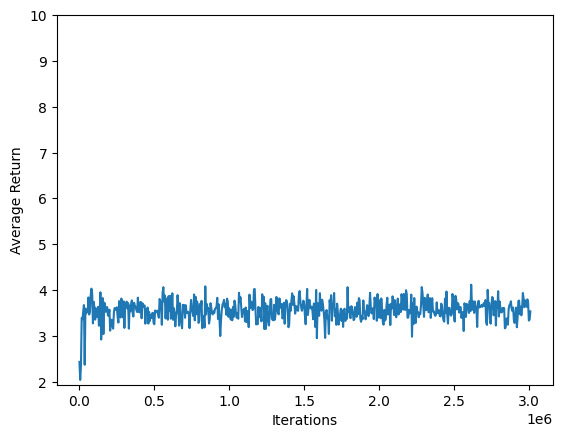

In [6]:
iterations = range(0, train_step_counter + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=10)